#https://www.kaggle.com/code/pankajj/fashion-mnist-with-pytorch-93-accuracy

PyTorch fornisce alcuni dataset pre-loaded che possono essere usati per provare dei modelli. Si possono trovare:
- Image Dataset
- Text Dataset
- Audio Dataset

Ecco un esempio per caricare Fashion-MNIST dataset da TorchVision. Questo dataset contiene circa 60000 immagini di articoli di Zalando che possono essere utilizzati come training dataset e ulteriori 10000 immagini da utilizzare come test dataset.
Ciascun esempio è un'immagine in grayscale 28x28 e ha un'etichetta associata che definisce una delle 10 classi di appartenenza.


In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

import datetime

C:\Users\nelli\anaconda3\envs\Deep2\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [3]:
#Convolutionary Neural Network
class MyCNN(nn.Module):
    
    def __init__(self):
        super(MyCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out


In [4]:
predictions_list = []
labels_list = []

In [5]:
def train(bs, lr):

    batch_size = bs 
    learning_rate = lr
    train_loader = torch.utils.data.DataLoader(training_data,batch_size)
    test_loader = torch.utils.data.DataLoader(test_data,batch_size)
    
    device = torch.device('cuda:0')
    
    num_epochs = 5
    count = 0
    model = MyCNN()
    model.to(device)
    error = nn.CrossEntropyLoss()
    learning_rate = 0.001
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)    
    
    training_start_time = datetime.datetime.now()
    results = []

    for epoch in range(num_epochs):
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            train = Variable(images.view(100, 1, 28, 28))
            labels = Variable(labels)
            outputs = model(train)
            loss = error(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            count += 1

        # Testing the model
            if not (count % 50):    # It's same as "if count % 50 == 0"
                total = 0
                correct = 0
                for images, labels in test_loader:
                    images, labels = images.to(device), labels.to(device)
                    labels_list.append(labels)
                    test = Variable(images.view(100, 1, 28, 28))
                    outputs = model(test)
                    predictions = torch.max(outputs, 1)[1].to(device)
                    predictions_list.append(predictions)
                    correct += (predictions == labels).sum()
                    total += len(labels)
                    
                accuracy = correct * 100 / total   
                new_results = {
                   "batch_size": batch_size,
                   "loss": loss.data.item(),
                   "iteration": count,
                   "accuracy": accuracy.item(),
                   "elapsed_time_sec": (datetime.datetime.now() - training_start_time).total_seconds(),
                }
                results.append(new_results)  
    return results

In [6]:
# batch_size = 100, learning_rate = 0.001
results = train(100, 0.001)

C:\Users\nelli\anaconda3\envs\Deep2\lib\site-packages\torch\nn\functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


In [7]:
import pandas as pd

results_df = pd.DataFrame.from_dict(results)
results_df.head(10)

,batch_size,loss,iteration,accuracy,elapsed_time_sec
0,100,0.549456,50,78.680000,4.770011
1,100,0.449008,100,81.519997,7.666718
2,100,0.513790,150,84.449997,10.254896
3,100,0.434090,200,85.599998,12.682994
4,100,0.424354,250,86.070000,15.455611
5,100,0.348596,300,86.839996,17.886880
6,100,0.338119,350,87.209999,20.646353
7,100,0.411364,400,84.680000,23.106270
8,100,0.621500,450,86.419998,25.801914
9,100,0.430898,500,87.680000,28.419534


In [8]:
results_df.tail()

,batch_size,loss,iteration,accuracy,elapsed_time_sec
55,100,0.259191,2800,89.930000,147.375217
56,100,0.433528,2850,89.629997,150.086596
57,100,0.217143,2900,90.930000,152.501081
58,100,0.207694,2950,89.529999,155.274581
59,100,0.198218,3000,90.290001,157.656414


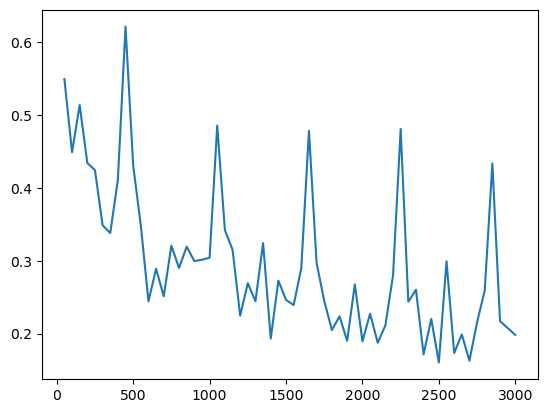

In [9]:
import matplotlib.pyplot as plt

plt.plot(results_df['iteration'], results_df['loss'])
plt.show()

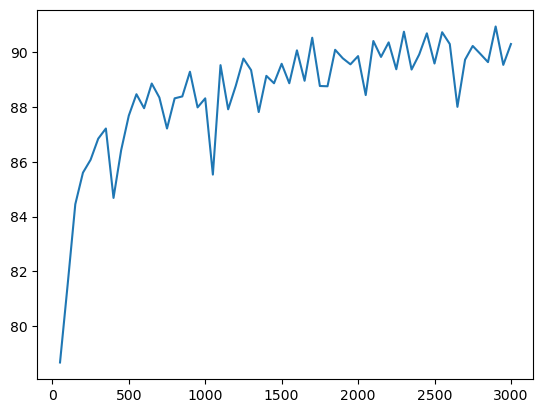

In [10]:
plt.plot(results_df['iteration'], results_df['accuracy'])
plt.show()

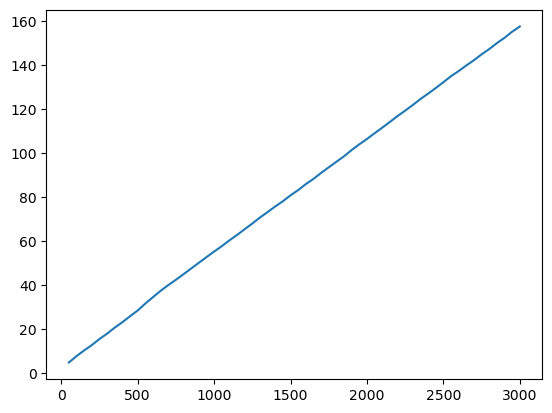

In [11]:
plt.plot(results_df['iteration'], results_df['elapsed_time_sec'])
plt.show()